#data extraction

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, mean_squared_error

In [7]:
df = pd.read_csv("/content/sbi_only_data.csv")

In [8]:
df.head()

,Bank Name,Bank Code,Banktype,Date,Month,Year,ATM(on-site),ATM(off-site),POS(on-line),POS(off-line),...,Amount of credit card transcations via others,No. of Debit Card,No.of debit transcations via ATM,No.of debit transcations via POS,Amount of debit card transactions via ATM(in millions),Amount of debit card transactions via POS(in millions),No.of debit transcations via Online(e-com),Amount of debit transcations via Online(e-com),No.of debit transcations via Others,Amount of debit transcations via Others
0,STATE BANK OF INDIA,B093,Public Sector Banks,31-01-2016,1,2016,19783.0,29216.0,289118.0,0.0,...,NaN,184348293,302493211.0,29712176,706067.991,32828.524,NaN,NaN,NaN,NaN
1,STATE BANK OF INDIA,B093,Public Sector Banks,29-02-2016,2,2016,20043.0,29261.0,296310.0,0.0,...,NaN,186970791,296735275.0,28469070,689132.024,29445.702,NaN,NaN,NaN,NaN
2,STATE BANK OF INDIA,B093,Public Sector Banks,31-03-2016,3,2016,20403.0,29321.0,302119.0,0.0,...,NaN,189341852,308423127.0,30331224,702058.746,29956.264,NaN,NaN,NaN,NaN
3,STATE BANK OF INDIA,B093,Public Sector Banks,30-04-2016,4,2016,20306.0,29418.0,307895.0,0.0,...,NaN,191393900,309235327.0,32648530,694301.321,33188.207,NaN,NaN,NaN,NaN
4,STATE BANK OF INDIA,B093,Public Sector Banks,31-05-2016,5,2016,20285.0,29495.0,312024.0,0.0,...,NaN,193461984,307780252.0,44189363,660952.247,34014.943,NaN,NaN,NaN,NaN


In [5]:
df.shape

(108, 32)

In [ ]:
df.head()

In [ ]:
sbi_df = df[df['Bank Name'].str.upper().str.contains("STATE BANK OF INDIA", na=False)]

# Save as Excel
sbi_df.to_excel("/content/sbi_only_data.xlsx", index=False)

# Optional: Download the Excel file to your local machine
from google.colab import files
files.download("/content/sbi_only_data.xlsx")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#atms tsa using SARIMA


In [97]:
df["ATM(on-site)"] = pd.to_numeric(df["ATM(on-site)"], errors='coerce')
df["ATM(off-site)"] = pd.to_numeric(df["ATM(off-site)"], errors='coerce')


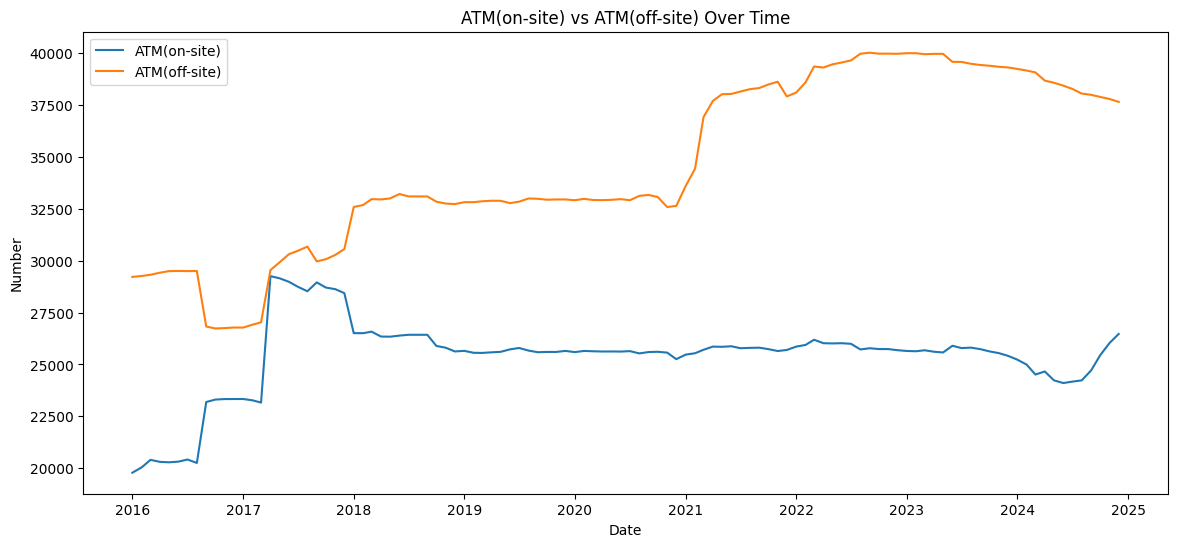

In [98]:
plt.figure(figsize=(14,6))
plt.plot(df.index, df['ATM(on-site)'], label="ATM(on-site)")
plt.plot(df.index, df['ATM(off-site)'], label="ATM(off-site)")
plt.xlabel("Date")
plt.ylabel("Number")
plt.title("ATM(on-site) vs ATM(off-site) Over Time")
plt.legend()
plt.show()


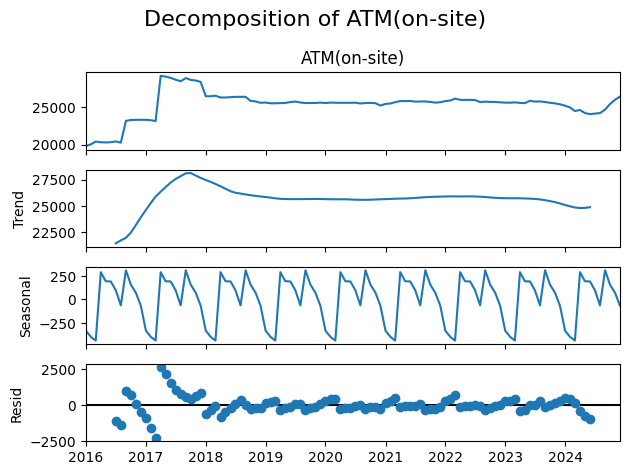

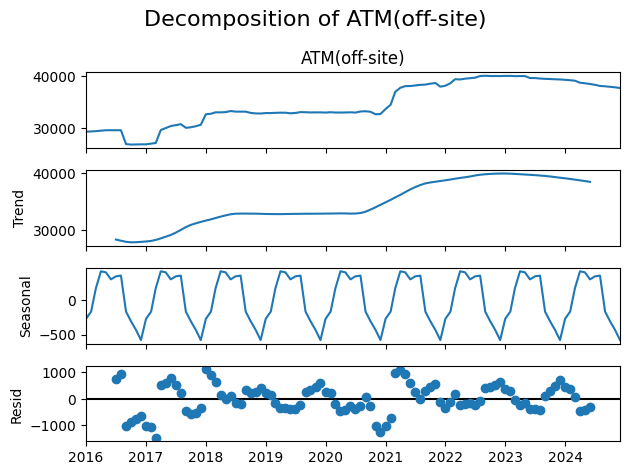

In [99]:
from statsmodels.tsa.seasonal import seasonal_decompose


tsa_cols = ['ATM(on-site)', 'ATM(off-site)']

for col in tsa_cols:
    series = df[col].dropna()
    if not isinstance(series.index, pd.DatetimeIndex):
        series.index = pd.to_datetime(series.index)
    if len(series) >= 24:
        fig = seasonal_decompose(series, model='additive', period=12).plot()
        fig.suptitle(f"Decomposition of {col}", fontsize=16)
        plt.tight_layout()
        plt.show()


In [100]:
from statsmodels.tsa.stattools import adfuller

for col in tsa_cols:
    series = df[col].dropna()
    result = adfuller(series)
    print(f'ADF Statistic for {col}: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] < 0.05:
        print('Series is stationary')
    else:
        print('Series is NOT stationary\nConsider differencing.')


ADF Statistic for ATM(on-site): -5.5046053754783495
p-value: 2.0351452105983078e-06
Series is stationary
ADF Statistic for ATM(off-site): -1.2146550194407408
p-value: 0.6672599353545298
Series is NOT stationary
Consider differencing.


In [101]:
# Assign the first-order difference as a new column
df['ATM(off-site)_diff'] = df['ATM(off-site)'].diff()


In [102]:
print(df[['ATM(off-site)', 'ATM(off-site)_diff']].head())


            ATM(off-site)  ATM(off-site)_diff
Date                                         
2016-01-01        29216.0                 NaN
2016-02-01        29261.0                45.0
2016-03-01        29321.0                60.0
2016-04-01        29418.0                97.0
2016-05-01        29495.0                77.0


In [103]:
from statsmodels.tsa.stattools import adfuller

# Select the differenced series, dropping NaNs (the first row will be NaN)
series = df['ATM(off-site)_diff'].dropna()
result = adfuller(series)

print(f"ADF Statistic: {result[0]}")
print(f"p-value: {result[1]}")
if result[1] < 0.05:
    print('Differenced series is stationary')
else:
    print('Differenced series is still NOT stationary')


ADF Statistic: -7.857773354589192
p-value: 5.384954412199705e-12
Differenced series is stationary


In [104]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

on_site_series = df['ATM(on-site)'].dropna()

# Try a basic SARIMA model. You can refine (p,d,q) & (P,D,Q,s) later.
model_on = SARIMAX(on_site_series, order=(1,0,1), seasonal_order=(1,0,1,12))
results_on = model_on.fit()
print(results_on.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


                                     SARIMAX Results                                      
Dep. Variable:                       ATM(on-site)   No. Observations:                  108
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -864.939
Date:                            Mon, 21 Jul 2025   AIC                           1739.878
Time:                                    15:03:16   BIC                           1753.289
Sample:                                01-01-2016   HQIC                          1745.316
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.008    123.614      0.000       0.984       1.016
ma.L1         -0.0018      0.510   

In [105]:
off_site_diff_series = df['ATM(off-site)_diff'].dropna()

model_off = SARIMAX(off_site_diff_series, order=(1,0,1), seasonal_order=(1,0,1,12))
results_off = model_off.fit()
print(results_off.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                      
Dep. Variable:                 ATM(off-site)_diff   No. Observations:                  107
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -816.499
Date:                            Mon, 21 Jul 2025   AIC                           1642.997
Time:                                    15:03:19   BIC                           1656.362
Sample:                                02-01-2016   HQIC                          1648.415
                                     - 12-01-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5296      0.583      0.908      0.364      -0.613       1.673
ma.L1         -0.2819      0.651   

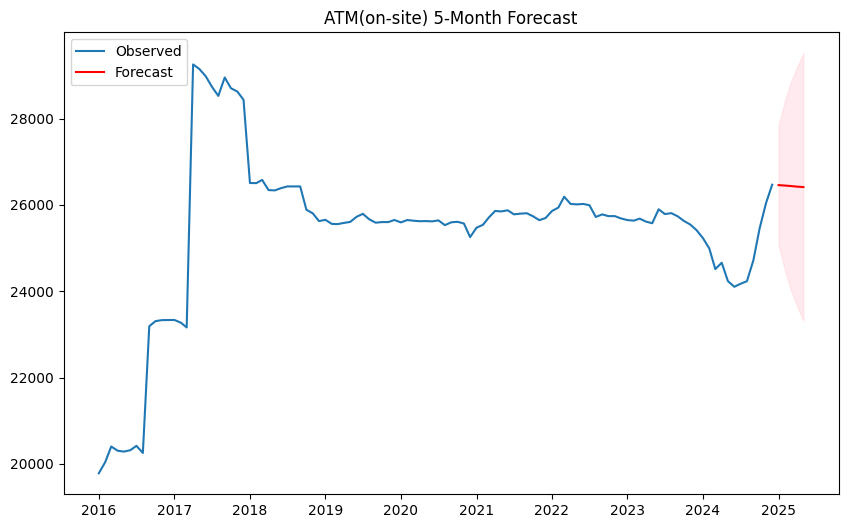

In [106]:
# Forecast next 5 months for ATM(on-site)
pred_on = results_on.get_forecast(steps=5)
pred_on_ci = pred_on.conf_int()

import matplotlib.pyplot as plt
plt.figure(figsize=(10,6))
plt.plot(on_site_series.index, on_site_series, label='Observed')
plt.plot(pred_on.predicted_mean.index, pred_on.predicted_mean, label='Forecast', color='red')
plt.fill_between(pred_on_ci.index,
                 pred_on_ci.iloc[:,0], pred_on_ci.iloc[:,1],
                 color='pink', alpha=0.3)
plt.title('ATM(on-site) 5-Month Forecast')
plt.legend()
plt.show()


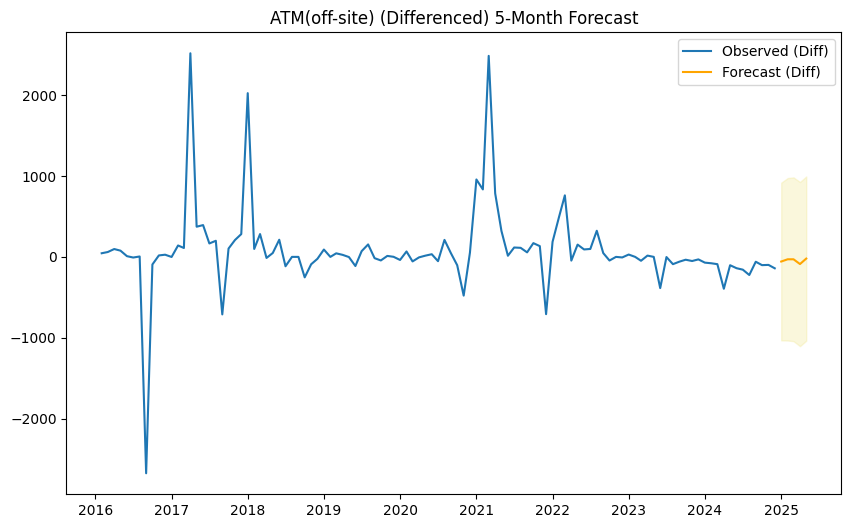

In [107]:
# Forecast next 5 months for ATM(off-site)_diff
pred_off = results_off.get_forecast(steps=5)
pred_off_ci = pred_off.conf_int()

plt.figure(figsize=(10,6))
plt.plot(off_site_diff_series.index, off_site_diff_series, label='Observed (Diff)')
plt.plot(pred_off.predicted_mean.index, pred_off.predicted_mean, label='Forecast (Diff)', color='orange')
plt.fill_between(pred_off_ci.index,
                 pred_off_ci.iloc[:,0], pred_off_ci.iloc[:,1],
                 color='khaki', alpha=0.3)
plt.title('ATM(off-site) (Differenced) 5-Month Forecast')
plt.legend()
plt.show()


In [108]:
# Invert differenced forecast to get level forecast
# Take the last actual ATM(off-site) value
last_actual = df['ATM(off-site)'].dropna().iloc[-1]
# Cumulative sum of predictions added to the last actual to get level forecasts
level_forecast = last_actual + pred_off.predicted_mean.cumsum()
print('5-Month Level Forecast for ATM(off-site):\n', level_forecast)


5-Month Level Forecast for ATM(off-site):
 2025-01-01    37588.537887
2025-02-01    37558.867509
2025-03-01    37529.253090
2025-04-01    37440.662720
2025-05-01    37419.749227
Freq: MS, Name: predicted_mean, dtype: float64


In [113]:

# Replace below with your dates if you have them; here we use a simple Month index
actual_data = {
    'Month': [1, 2, 3, 4, 5],
    'On-site': [27254, 27375, 27371, 27276, 27458],
    'Off-site': [37739, 36941, 36487, 36373, 36105]
}
actual_df = pd.DataFrame(actual_data).set_index('Month')


In [110]:
# Extract forecasted values as numpy arrays for easy calculation
forecast_on = pred_on.predicted_mean.values        # 5 values for ATM(on-site)
# For ATM(off-site) use level_forecast if you forecasted the levels, else use pred_off.predicted_mean
forecast_off = level_forecast.values               # 5 values for ATM(off-site)


In [111]:
# Add forecasts to actual DataFrame
actual_df['Forecast_On-site'] = forecast_on
actual_df['Forecast_Off-site'] = forecast_off


In [112]:


# ATM(on-site)
mae_on = mean_absolute_error(actual_df['On-site'], actual_df['Forecast_On-site'])
mse_on = mean_squared_error(actual_df['On-site'], actual_df['Forecast_On-site'])
rmse_on = mse_on ** 0.5
mape_on = (abs((actual_df['On-site'] - actual_df['Forecast_On-site']) / actual_df['On-site']).mean()) * 100

# ATM(off-site)
mae_off = mean_absolute_error(actual_df['Off-site'], actual_df['Forecast_Off-site'])
mse_off = mean_squared_error(actual_df['Off-site'], actual_df['Forecast_Off-site'])
rmse_off = mse_off ** 0.5
mape_off = (abs((actual_df['Off-site'] - actual_df['Forecast_Off-site']) / actual_df['Off-site']).mean()) * 100

print("ATM(on-site) - MAE:", mae_on, " RMSE:", rmse_on, " MAPE:", mape_on, "%")
print("ATM(off-site) - MAE:", mae_off, " RMSE:", rmse_off, " MAPE:", mape_off, "%")


ATM(on-site) - MAE: 910.794928993901  RMSE: 914.6658046042393  MAPE: 3.32973993127662 %
ATM(off-site) - MAE: 838.5989317976448  RMSE: 933.7194251219335  MAPE: 2.3009105561336862 %


In [34]:
print(actual_df)


       On-site  Off-site  Forecast_On-site  Forecast_Off-site
Month                                                        
1        27254     37739      26458.329369       37588.537887
2        27375     36941      26448.056738       37558.867509
3        27371     36487      26437.601277       37529.253090
4        27276     36373      26422.906937       37440.662720
5        27458     36105      26413.131034       37419.749227


#atms holts winters expo smoothing

In [35]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit Holt-Winters to ATM(on-site)
model_hw_on = ExponentialSmoothing(on_site_series, trend='add', seasonal='add', seasonal_periods=12)
results_hw_on = model_hw_on.fit()

# Forecast next 5 months
hw_forecast_on = results_hw_on.forecast(steps=5)

print("ATM(on-site) Holt-Winters 5-month forecast:")
print(hw_forecast_on)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ATM(on-site) Holt-Winters 5-month forecast:
2025-01-01    26230.964172
2025-02-01    26244.669795
2025-03-01    26283.824836
2025-04-01    26929.387613
2025-05-01    26861.124904
Freq: MS, dtype: float64


In [36]:
model_hw_off = ExponentialSmoothing(df['ATM(off-site)'].dropna(), trend='add', seasonal='add', seasonal_periods=12)
results_hw_off = model_hw_off.fit()

# Forecast next 5 months
hw_forecast_off = results_hw_off.forecast(steps=5)

print("ATM(off-site) Holt-Winters 5-month forecast:")
print(hw_forecast_off)


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


ATM(off-site) Holt-Winters 5-month forecast:
2025-01-01    38043.336635
2025-02-01    38220.669572
2025-03-01    38615.077765
2025-04-01    38946.315377
2025-05-01    39044.421712
Freq: MS, dtype: float64


In [37]:
# Add Holt-Winters forecasts to comparison DataFrame
actual_df['HW_Forecast_On-site'] = hw_forecast_on.values
actual_df['HW_Forecast_Off-site'] = hw_forecast_off.values

from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# On-site accuracy
mae_hw_on = mean_absolute_error(actual_df['On-site'], actual_df['HW_Forecast_On-site'])
rmse_hw_on = np.sqrt(mean_squared_error(actual_df['On-site'], actual_df['HW_Forecast_On-site']))
mape_hw_on = (abs((actual_df['On-site'] - actual_df['HW_Forecast_On-site']) / actual_df['On-site']).mean()) * 100

# Off-site accuracy
mae_hw_off = mean_absolute_error(actual_df['Off-site'], actual_df['HW_Forecast_Off-site'])
rmse_hw_off = np.sqrt(mean_squared_error(actual_df['Off-site'], actual_df['HW_Forecast_Off-site']))
mape_hw_off = (abs((actual_df['Off-site'] - actual_df['HW_Forecast_Off-site']) / actual_df['Off-site']).mean()) * 100

print(f"ATM(on-site) Holt-Winters MAE: {mae_hw_on}, RMSE: {rmse_hw_on}, MAPE: {mape_hw_on}%")
print(f"ATM(off-site) Holt-Winters MAE: {mae_hw_off}, RMSE: {rmse_hw_off}, MAPE: {mape_hw_off}%")

# View the comparison table
print(actual_df)


ATM(on-site) Holt-Winters MAE: 836.805736221432, RMSE: 892.4795284530679, MAPE: 3.05985999462113%
ATM(off-site) Holt-Winters MAE: 1844.964212385322, RMSE: 2074.658622876218, MAPE: 5.063810531922995%
       On-site  Off-site  Forecast_On-site  Forecast_Off-site  \
Month                                                           
1        27254     37739      26458.329369       37588.537887   
2        27375     36941      26448.056738       37558.867509   
3        27371     36487      26437.601277       37529.253090   
4        27276     36373      26422.906937       37440.662720   
5        27458     36105      26413.131034       37419.749227   

       HW_Forecast_On-site  HW_Forecast_Off-site  
Month                                             
1             26230.964172          38043.336635  
2             26244.669795          38220.669572  
3             26283.824836          38615.077765  
4             26929.387613          38946.315377  
5             26861.124904          390

#atm var


In [87]:
from statsmodels.tsa.api import VAR

# Use only the necessary columns and drop any missing data
cols = ['ATM(on-site)', 'ATM(off-site)']
df_var = df[cols].dropna()

# Ensure the index is datetime, and sorted
df_var = df_var.sort_index()
if not isinstance(df_var.index, pd.DatetimeIndex):
    df_var.index = pd.to_datetime(df_var.index)

# Display the last date - should be December 2024
print("Last available month in dataset:", df_var.index[-1])


Last available month in dataset: 2024-12-01 00:00:00


In [42]:
model = VAR(df_var)
lag_order_results = model.select_order(maxlags=12)
print(lag_order_results.summary())
best_lag = lag_order_results.aic

results = model.fit(best_lag)


 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0        30.44       30.49   1.656e+13       30.46
1        25.09      25.25*   7.904e+10       25.16
2        25.07       25.33   7.703e+10       25.18
3        25.13       25.50   8.176e+10       25.28
4        25.19       25.67   8.703e+10       25.38
5        25.21       25.80   8.925e+10       25.45
6        25.18       25.87   8.628e+10       25.46
7        25.24       26.04   9.215e+10       25.57
8        24.74       25.65   5.581e+10       25.10
9        24.77       25.78   5.775e+10       25.18
10      24.43*       25.55  4.139e+10*      24.89*
11       24.44       25.67   4.208e+10       24.94
12       24.48       25.82   4.387e+10       25.02
--------------------------------------------------


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [43]:
forecast = results.forecast(df_var.values, steps=5)

# Create a date index for Jan 2025 – May 2025
last_date = df_var.index[-1]
# If last_date is Timestamp('2024-12-01') or Timestamp('2024-12-31'), adapt accordingly:
forecast_index = pd.date_range(last_date + pd.DateOffset(months=1), periods=5, freq='MS')

forecast_df = pd.DataFrame(forecast, index=forecast_index, columns=cols)
print("\nJan 2025 to May 2025 forecast (VAR):")
print(forecast_df)



Jan 2025 to May 2025 forecast (VAR):
            ATM(on-site)  ATM(off-site)
2025-01-01  26315.826130   37472.469647
2025-02-01  26290.454854   37151.298280
2025-03-01  26262.929607   36942.364135
2025-04-01  26213.860667   36868.792388
2025-05-01  26377.877927   36932.157408


In [44]:
# forecast_df: already has Jan-May 2025 as index & columns as atm types
# actual_df: just built above

combined = actual_df.join(forecast_df, lsuffix='_actual', rsuffix='_forecast')
print(combined)


       On-site  Off-site  Forecast_On-site  Forecast_Off-site  \
Month                                                           
1        27254     37739      26458.329369       37588.537887   
2        27375     36941      26448.056738       37558.867509   
3        27371     36487      26437.601277       37529.253090   
4        27276     36373      26422.906937       37440.662720   
5        27458     36105      26413.131034       37419.749227   

       HW_Forecast_On-site  HW_Forecast_Off-site  ATM(on-site)  ATM(off-site)  
Month                                                                          
1             26230.964172          38043.336635           NaN            NaN  
2             26244.669795          38220.669572           NaN            NaN  
3             26283.824836          38615.077765           NaN            NaN  
4             26929.387613          38946.315377           NaN            NaN  
5             26861.124904          39044.421712           NaN  

In [88]:

# You may need to adjust if your DataFrame uses a different name for the index or columns
actual_on = combined['On-site']
actual_off = combined['Off-site']
forecast_on = combined['Forecast_On-site']
forecast_off = combined['Forecast_Off-site']

# ATM(on-site)
mae_on = mean_absolute_error(actual_on, forecast_on)
rmse_on = mean_squared_error(actual_on, forecast_on) ** 0.5
mape_on = (abs((actual_on - forecast_on) / actual_on).mean()) * 100

# ATM(off-site)
mae_off = mean_absolute_error(actual_off, forecast_off)
rmse_off = mean_squared_error(actual_off, forecast_off) ** 0.5
mape_off = (abs((actual_off - forecast_off) / actual_off).mean()) * 100

print(f"ATM(on-site) VAR MAE: {mae_on:.2f}, RMSE: {rmse_on:.2f}, MAPE: {mape_on:.2f}%")
print(f"ATM(off-site) VAR MAE: {mae_off:.2f}, RMSE: {rmse_off:.2f}, MAPE: {mape_off:.2f}%")


ATM(on-site) VAR MAE: 910.79, RMSE: 914.67, MAPE: 3.33%
ATM(off-site) VAR MAE: 838.60, RMSE: 933.72, MAPE: 2.30%


In [47]:
# Holt-Winters Accuracy
hw_on = combined['HW_Forecast_On-site']
hw_off = combined['HW_Forecast_Off-site']

mae_hw_on = mean_absolute_error(actual_on, hw_on)
rmse_hw_on = mean_squared_error(actual_on, hw_on) ** 0.5
mape_hw_on = (abs((actual_on - hw_on) / actual_on).mean()) * 100

mae_hw_off = mean_absolute_error(actual_off, hw_off)
rmse_hw_off = mean_squared_error(actual_off, hw_off) ** 0.5
mape_hw_off = (abs((actual_off - hw_off) / actual_off).mean()) * 100

print(f"ATM(on-site) HW MAE: {mae_hw_on:.2f}, RMSE: {rmse_hw_on:.2f}, MAPE: {mape_hw_on:.2f}%")
print(f"ATM(off-site) HW MAE: {mae_hw_off:.2f}, RMSE: {rmse_hw_off:.2f}, MAPE: {mape_hw_off:.2f}%")


ATM(on-site) HW MAE: 836.81, RMSE: 892.48, MAPE: 3.06%
ATM(off-site) HW MAE: 1844.96, RMSE: 2074.66, MAPE: 5.06%


#atm varima

In [86]:

cols = ['ATM(on-site)', 'ATM(off-site)']
df_varima = df[cols].dropna()

# Ensure index is DateTime and sorted
df_varima = df_varima.sort_index()
if not isinstance(df_varima.index, pd.DatetimeIndex):
    df_varima.index = pd.to_datetime(df_varima.index)


In [85]:
from statsmodels.tsa.statespace.varmax import VARMAX

# Fit the model (if your data is not stationary, use integrated series or set trend='c' for constant)
model_varima = VARMAX(df_varima, order=(1, 1))  # (p, q)
results_varima = model_varima.fit(disp=False)
print(results_varima.summary())


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/varmax.py:160: EstimationWarning: Estimation of VARMA(p,q) models is not generically robust, due especially to identification issues.
  warn('Estimation of VARMA(p,q) models is not generically robust,'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                                                                                         Statespace Model Results                                                                                                         
Dep. Variable:     ['POS(Total)', 'No. of Credit Card', 'No. of Debit Card', 'Amount of credit card transactions via POS(in millions)', 'Amount of debit card transactions via POS(in millions)']   No. Observations:                   87
Model:                                                                                                                                                                                 VARMA(1,1)   Log Likelihood               -5631.220
                                                                                                                                                                                      + intercept   AIC                          11402.440
Date:                                                       

In [50]:
# Last date in your data
last_date = df_varima.index[-1]
# Build index for forecast periods
forecast_index = pd.date_range(last_date + pd.DateOffset(months=1), periods=5, freq="MS")

# Forecast 5 steps ahead
forecast_varima = results_varima.forecast(steps=5)
forecast_varima.index = forecast_index

print("VARIMA 5-step forecast (Jan-May 2025):")
print(forecast_varima)


VARIMA 5-step forecast (Jan-May 2025):
            ATM(on-site)  ATM(off-site)
2025-01-01  26268.041964   37667.255250
2025-02-01  26068.281193   37709.964184
2025-03-01  25884.441235   37737.626279
2025-04-01  25715.590950   37751.726060
2025-05-01  25560.836121   37753.646418


In [52]:
print(combined_varima.columns)


Index(['On-site', 'Off-site', 'Forecast_On-site', 'Forecast_Off-site',
       'HW_Forecast_On-site', 'HW_Forecast_Off-site', 'ATM(on-site)',
       'ATM(off-site)'],
      dtype='object')


In [84]:

# ATM(on-site)
mae_on = mean_absolute_error(combined_varima['On-site'], combined_varima['Forecast_On-site'])
rmse_on = mean_squared_error(combined_varima['On-site'], combined_varima['Forecast_On-site']) ** 0.5
mape_on = ((abs(combined_varima['On-site'] - combined_varima['Forecast_On-site']) / combined_varima['On-site']).mean()) * 100

# ATM(off-site)
mae_off = mean_absolute_error(combined_varima['Off-site'], combined_varima['Forecast_Off-site'])
rmse_off = mean_squared_error(combined_varima['Off-site'], combined_varima['Forecast_Off-site']) ** 0.5
mape_off = ((abs(combined_varima['Off-site'] - combined_varima['Forecast_Off-site']) / combined_varima['Off-site']).mean()) * 100

print(f"ATM(on-site) VARIMA MAE: {mae_on:.2f}, RMSE: {rmse_on:.2f}, MAPE: {mape_on:.2f}%")
print(f"ATM(off-site) VARIMA MAE: {mae_off:.2f}, RMSE: {rmse_off:.2f}, MAPE: {mape_off:.2f}%")


ATM(on-site) VARIMA MAE: 910.79, RMSE: 914.67, MAPE: 3.33%
ATM(off-site) VARIMA MAE: 838.60, RMSE: 933.72, MAPE: 2.30%
